In [96]:
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine
from sqlalchemy import Column, Integer, String, Float, and_, Date, desc, func
from monthdelta import monthdelta

In [97]:
engine = create_engine("sqlite:///hawaii.sqlite", echo=False)

In [98]:
# Reflect Database into ORM classes
Base = automap_base()
Base.prepare(engine, reflect=True)
# Print all of the classes mapped to the Base
Base.classes.keys()

['measurement', 'station']

In [99]:
# Save a reference to the measurement table as `measurement`
Measurement=Base.classes.measurement
# Save a reference to the station table as `station`
Station=Base.classes.station

In [100]:
# Create a database session object
session=Session(engine)

# Printing the total dates in Measurement table
session.query(func.count(Measurement.date)).all()

[(19550)]

# Preciptation Analysis

In [101]:
#Design a query to retrieve the last 12 months of precipitation data.
#Getting the last Date in the Dataset
last_date = session.query(Measurement, Measurement.date).order_by(Measurement.date.desc()).first()[1]
print(last_date)

2017-08-23


In [102]:
# Substracting 12 months from the last date in Dataset(1 year ago from the latest date)
last = datetime.strptime(last_date, '%Y-%m-%d')
year_ago = last - monthdelta(12)
print(year_ago)

2016-08-23 00:00:00


In [103]:
#Select only the date and prcp values.
precipitation_list = session.query(Measurement.date,Measurement.prcp).filter(Measurement.date > year_ago).order_by(Measurement.date).all()
precipitation_list[:5]

[('2016-08-24', 0.08),
 ('2016-08-24', 2.15),
 ('2016-08-24', 2.28),
 ('2016-08-24', 0.0),
 ('2016-08-24', 1.22)]

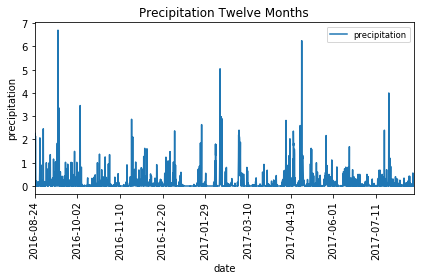

In [104]:
#Load the query results into a Pandas DataFrame and set the index to the date column.
pcp_df = pd.DataFrame(precipitation_list, columns=["date", "precipitation"])
pcp_df= pcp_df.set_index("date")

# 
df_prec.plot()
plt.xticks(rotation='vertical')
plt.title("Precipitation Twelve Months")
plt.xlabel("date")
plt.ylabel("precipitation")
plt.legend(fontsize="small",loc="best")
plt.tight_layout()
plt.show()

In [105]:
# give summary statistics of the dataframe
pcp_df.describe()

,precipitation
count,2223.000000
mean,0.159951
std,0.441220
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,6.700000


# Station Analysis

In [106]:
# calculate the number of stations
num_stations = session.query(Station.station).count()
print("The number of stations is: %s" % num_stations)

The number of stations is: 9


In [107]:
# find the most active station
active_stations = session.query(Measurement.station, func.count(Measurement.date)).group_by(Measurement.station).order_by(desc(func.count(Measurement.date))).all()

most_active = active_stations[0][0]
num_observations = active_stations[0][1]

print("The most active station is: %s" % most_active)
print("Number of observations for station %s: %s" % (most_active, num_observations))

The most active station is: USC00519281
Number of observations for station USC00519281: 2772


In [108]:
# get the last 12 months of temperature data

temp_year = session.query(Measurement.date, Measurement.tobs).filter(and_(Measurement.date > year_ago,
                                                                         Measurement.station == most_active)).all()

# create the dataframe and set date as the index
temp_df = pd.DataFrame(temp_year, columns = ["date", "tobs"])
temp_df.set_index('date', inplace=True)

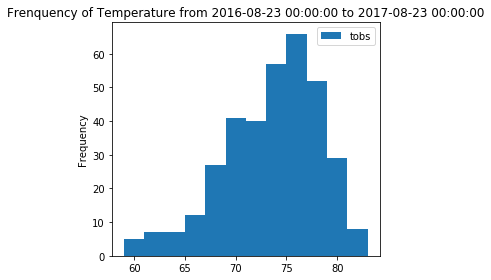

In [109]:
# create a histogram of the temperature data
temp_df.iloc[::-1].plot.hist(title="Frenquency of Temperature from %s to %s" % (year_ago, last), bins = 12)
plt.tight_layout()
plt.show()

# Temperature Analysis

In [110]:
import datetime 
start_date = datetime.date(2018,6,6)
end_date = datetime.date(2018,6,10)

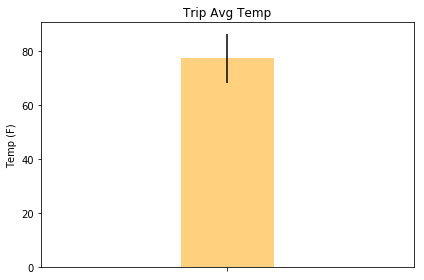

In [111]:
def calc_temps(start, end):
    # calculate the date 1 year ago
    end_last = end - datetime.timedelta(365)
    start_last=start - datetime.timedelta(365)
    # get the maximum temperature
    max_temp = session.query(func.max(Measurement.tobs)).filter(and_(Measurement.date <= end_last, Measurement.date >= start_last)).all()
    maximum = max_temp[0][0]
    
    # get the minimum temperature
    min_temp = session.query(func.min(Measurement.tobs)).filter(and_(Measurement.date <= end_last, Measurement.date >= start_last)).all()
    minimum = min_temp[0][0]
    
    # get the average temperature
    avg_temp = session.query(func.avg(Measurement.tobs)).filter(and_(Measurement.date <= end_last, Measurement.date >= start_last)).all()
    average = avg_temp[0][0]
    
    # create the plot
    objects = [str(end)]
    x_axis = np.arange(len(objects))
    fig, ax = plt.subplots()
    temp_plot = ax.bar(x_axis, average, yerr=(maximum-minimum), color = "orange", alpha = .5, width = .5)
    tick_locations = [value for value in x_axis]
    plt.xticks(tick_locations, [])
    plt.xlim(-1, len(x_axis))
    plt.title("Trip Avg Temp")
    plt.ylabel("Temp (F)")
    plt.tight_layout()
    plt.show()

# call the function
calc_temps(start_date, end_date)

# Optional Recommended Analysis